# LLM detection
## Assignment #3
###  Practical Data Science course, MSc in Data Science (2023/2024)

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Data Augmentation

We begin by reviewing the data provided to us by the competition:

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os


DATA_PATH = os.path.join("..", "data")

In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_essays.csv"))
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


Out of these we have been provided with only 3 generated essays:

In [3]:
train_df[train_df.generated == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


### Prompting

Unless we procure more data the task is impossible. We will thus use prompting to produce our own generated dataset.

For this task we will use ChatGPT. The prompts were manually given using the official website, and exported the responses in MarkDown form using the very convinient [ChatGPT Conv Down](https://addons.mozilla.org/en-US/firefox/addon/chatgpt-convdown/) Firefox addon. 

We used three prompting strategies to procure our generated dataset:
* The standard prompt (used for the human essays) without sources
* The standard prompt using all the sources, with a role prompt to persuade the model into writing in a more simplistic tone mirroring the tone used in the human essays
* The standard prompt with a role prompt, using a different subset of the sources each time 
* The standard prompt with a role prompt and a different subset of the human essays instead of sources, in order to "mimick" the tone and style of these essays

This procedure was repeated for both types of prompts provided in the dataset (car-free cities and the Electoral College). The conversation context was periodically refreshed in order to avoid the model repeating its own generated essays. Following this procedure we hope to obtain a thorough dataset being as close as possible to the actual operational dataset.

Details on the prompts themselves can be found in `report.pdf`.

### Dataset Caveats

Unfortunately, even following the above strategy does not yield as good results as we would hope for. The biggest isse by far is that ChatGPT's output is formulaic and carries a distinct tone which is most of the time distinct from the students'. 

Role prompting and including human essays as input slightly alleviates the problem but does not eradicate it. Trying to explictly set the tone of the generated essays leads to a complete collapse in tone, with outputs as *artistic* as the one below:

>Dear [Senator's Name],
>
>Hope this letter finds you chill. I wanted to throw my two cents into the mix about the whole Electoral College debate. It's like a hot topic, right? Some say we should keep it, others are all about switching to the popular vote. Here's where I'm at.
>
>So, keeping the Electoral College – it's got its quirks, but it's not all bad. I get it, voting for electors instead of the actual president seems a bit weird. But, like, it's been working, hasn't it? It's like a system our folks set up ages ago, and yeah, maybe it's not perfect, but it's got a rhythm." [...]


In [4]:
import os


OUTPUT_DIR = "..\output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    """
    Save a pandas DataFrame to a CSV file.

    :param df: The DataFrame to be saved.
    :type df: pd.DataFrame

    :param filename: The name of the CSV file.
    :type filename: str

    :return: This function does not return anything.
    :rtype: None
    """
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file, encoding = 'utf8')
    print(f"File saved successfully as {file}")


def save_plot(filename: str) -> None:
    """
    Saves a plot to the output directory.

    :param filename: The name of the file for the Figure.
    :type filename: str
    """
    path = os.path.join(OUTPUT_DIR, filename)
    plt.savefig(path, bbox_inches="tight")
    print(f"Figured saved to " + path)

### Importing the generated dataset

In [5]:
def read_gpt(file: str) -> pd.Series:
    """
    Read and extract ChatGPT responses from a file.

    :param file: A string specifying the name of the file to be read.
    :type file: str

    :return: A pandas Series containing ChatGPT responses extracted from the file.
    :rtype: pd.Series
    """
    with open(os.path.join(DATA_PATH, file), encoding="utf8") as f:
        contents = f.read()
    responses = list(filter(lambda x: x.startswith(" ChatGPT"), 
                        contents.split("##")))
    clear_responses = [res.replace("ChatGPT", "").replace("~", "").strip() 
                            for res in responses]
    return pd.Series(clear_responses)


def create_gpt_dataset(input_file_name: str, prompt_id: int):
    data_text = read_gpt(input_file_name)
    df = pd.DataFrame({"id": [str(id(text)) for text in data_text],
                     "text": data_text, 
                     "prompt_id": np.full_like(data_text, prompt_id),
                     "generated": np.ones_like(data_text)})
    df.prompt_id = df.prompt_id.astype(int)
    df.generated = df.generated.astype(int)
    return df
    

envir_df = create_gpt_dataset("chatgpt_cars.md", prompt_id=0)
elect_df = create_gpt_dataset("chatgpt_electoral.md", prompt_id=1)

We will export the entire dataset, but will only use a subset of it in training. This is because of the low quality data encountered in the first prompts, where the generated texts do not match the tone or the contents of the human essays.

In [6]:
# discard most low-quality datapoints
original_df = pd.concat([envir_df[80:], elect_df[80:], train_df])
original_df

,id,text,prompt_id,generated
80,2773000545664,Limiting car usage offers numerous advantages ...,0,1
81,2773038626192,Limiting car usage presents a myriad of advant...,0,1
82,2773038634128,Limiting car usage offers a range of advantage...,0,1
83,2773038638656,Limiting car usage brings forth numerous advan...,0,1
84,2773040001136,Limiting car usage presents a myriad of advant...,0,1
...,...,...,...,...
1373,fe6ff9a5,There has been a fuss about the Elector Colleg...,1,0
1374,ff669174,Limiting car usage has many advantages. Such a...,0,0
1375,ffa247e0,There's a new trend that has been developing f...,0,0
1376,ffc237e9,As we all know cars are a big part of our soci...,0,0


### Preprocessing

We execute the following preprocessing steps:
* Remove all placeholder tags such as [Your Name], and which are exclusively used by ChatGPT
* Turn all text to lowercase
* Remove stopwords

In [7]:
df = original_df.copy()

In [8]:
# sample text
df.text.loc[df.text.apply(lambda x: x.startswith("Dear"))].iloc[3]

"Dear [State Senator's Name],\n\nHope this letter finds you well. I'm writing to share my perspective on the Electoral College and why I believe it's essential to keep it in place for electing the President of the United States.\n\nFirstly, the Electoral College ensures that every state has a say in the election, preventing candidates from focusing solely on populous states and neglecting the concerns of smaller ones. The winner-takes-all system encourages candidates to campaign in various states, considering the diverse needs and opinions of Americans nationwide. This approach prevents the concentration of power in densely populated urban areas, giving a voice to citizens in rural and less populous regions.\n\nMoreover, the Electoral College promotes stability and avoids the potential chaos of close popular vote outcomes. As history shows, candidates can win the popular vote but lose the Electoral College, as seen in the case of Al Gore in 2000. This system acts as a safeguard against

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections.abc import Iterable


def remove_stopwords(words: str, stop_words: Iterable[str]) -> str:
    word_tokens = word_tokenize(words)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)


def preprocess(text: pd.Series) -> pd.Series:
    bracket_regex = r"\[.*?\]"

    text = text.apply(lambda x: re.sub(bracket_regex, "", x))
    text = text.apply(lambda x: x.lower())

    stop_words = set(stopwords.words('english'))
    text = text.apply(lambda x: remove_stopwords(x, stop_words))
    
    return text

The resulting text resembles the following:

In [10]:
df.text = preprocess(df.text)
df.text.loc[df.text.apply(lambda x: x.startswith("dear"))].iloc[3]

"dear , hope letter finds well . 'm writing share perspective electoral college believe 's essential keep place electing president united states . firstly , electoral college ensures every state say election , preventing candidates focusing solely populous states neglecting concerns smaller ones . winner-takes-all system encourages candidates campaign various states , considering diverse needs opinions americans nationwide . approach prevents concentration power densely populated urban areas , giving voice citizens rural less populous regions . moreover , electoral college promotes stability avoids potential chaos close popular vote outcomes . history shows , candidates win popular vote lose electoral college , seen case al gore 2000. system acts safeguard challenges controversies might arise purely popular vote , ensuring clear decisive outcome . electoral college also simplifies presidential election process providing structured systematic way choosing president . without , process c

In [11]:
print(f"Number of generated essays in the dataset: {(df.generated == 1).sum()}")

Number of generated essays in the dataset: 152


In [12]:
# check for null values
df.isnull().values.any()

False

We also may need to convert the dataframe's types.

### More augmentation?

Another idea would be to use other standard NLP augmentation techniques such as randomly deleting/inserting words, purposefully inserting typographical mistakes in the text or even [replacing words with close synonyms](https://www.kaggle.com/code/rohitsingh9990/data-augmentation-by-synonym-replacement). However, all of these strategies would ultimately hurt the quality of our dataset, since typos and specific words are very valuable tools in LLM detection.

## Classifiers

In this section we train multiple classifiers on our data. 

Before we begin we must select an appropriate text representation, since our classifiers only work with numerical vectors, not strings. The two implementations that we use are:
* TF-IDF vectors
* Word2Vec embeddings

Both approaches have upsides and downsides. TF-IDF vectors are adept at automatically selecting features by weighting, assinging more importance to rare words. Word2Vec vectors on the other hand are dense document embeddings which take into account the semantic meaning of the words and not just their frequency. The downside is their fixed size (300x1 embedding for any word), which means that we either need to concatenate the vectors of each word in the text, or use a merging scheme in order to produce a document embedding from the individual word embeddings. In this study, we use the default Word2Vec behavior, which averages the word embeddings. While powerful, this technique may lead to significant data loss and overfitting if we are not sure the document embeddings of the train set are similar to the operational set (the data our algorithms will be run on and which aren't included in the train and test sets).

The goal is to use the simplest model possible that has an acceptably efficient performance. We start with discriminant classifiers such as **Naive Bayes** and **Logistic Regression** and consider Ensemble learning classifiers such as **Random Forest** and **Adaboost**. The results guide us on whether we would need to use more powerful NLP models such as RNNs, LSTMs or even (pretrained) Transformers. 

In [13]:
print("Downloading Word2Vec model...")

In [14]:
%%capture
!python -m spacy download en_core_web_md

In [15]:
print("Model downloaded.")

Model downloaded.


In [16]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Loading Word2Vec model...
Model loaded.


In [17]:
def compute_embeddings(text: Iterable[str]) -> list[str]:
    embeddings = []
    
    print("Computing embeddings...")
    for text in tqdm(text):
        embeddings.append(word2vec(text).vector)
        
    return embeddings

df["embedding"] = compute_embeddings(df.text)
df

Computing embeddings...


  0%|          | 0/1527 [00:00<?, ?it/s]

,id,text,prompt_id,generated,embedding
80,2773000545664,limiting car usage offers numerous advantages ...,0,1,"[-0.98624474, -0.038121544, -1.8818331, 0.1376..."
81,2773038626192,limiting car usage presents myriad advantages ...,0,1,"[-1.1210637, -0.14010453, -1.875791, 0.4314957..."
82,2773038634128,limiting car usage offers range advantages ext...,0,1,"[-0.9631841, -0.092236586, -1.8918346, 0.15222..."
83,2773038638656,limiting car usage brings forth numerous advan...,0,1,"[-0.94708604, -0.26262596, -1.7073458, 0.11121..."
84,2773040001136,limiting car usage presents myriad advantages ...,0,1,"[-1.113946, -0.19865415, -1.9179273, 0.2551637..."
...,...,...,...,...,...
1373,fe6ff9a5,fuss elector college . many people get confuse...,1,0,"[-1.4767352, 0.04409365, -2.265938, 0.2277243,..."
1374,ff669174,limiting car usage many advantages . putting l...,0,0,"[-0.20308205, 0.864372, -3.5353804, 0.25371215..."
1375,ffa247e0,"'s new trend developing years , soon full thro...",0,0,"[-0.80689734, 0.0152280945, -2.0881786, -0.199..."
1376,ffc237e9,know cars big part society today . however car...,0,0,"[-0.65920925, 0.18932514, -2.4064806, -0.80102..."


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_data_from_text(data_train, data_test):
    vectorizer = TfidfVectorizer().fit(data_train.text)
    x_train = vectorizer.transform(data_train.text)
    x_test = vectorizer.transform(data_test.text)
    
    embed_x_train = np.array([x for x in data_train.embedding])
    embed_x_test = np.array([x for x in data_test.embedding])
    
    y_train = data_train.generated.values
    y_test = data_test.generated.values

    return {"vectorizer": vectorizer, 
            "x_train": x_train, 
            "y_train": y_train,
            "x_test": x_test, 
            "y_test": y_test, 
            "embed_x_train": embed_x_train, 
            "embed_x_test": embed_x_test}

In [19]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(df,
                                         train_size=0.7, 
                                         test_size=0.3, 
                                         stratify=df.generated,
                                         random_state=42)

data = get_data_from_text(data_train, data_test)

vectorizer = data["vectorizer"]
x_train = data["x_train"]
x_test = data["x_test"]

embed_x_train = data["embed_x_train"]
embed_x_test = data["embed_x_test"]

y_train = data["y_train"]
y_test = data["y_test"]

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because we have an unbalanced dataset (Generated essays data are a small fraction of overall essays)


Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [20]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res.mean(), res.std()

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

In [21]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier


majority_model = DummyClassifier(strategy="most_frequent")
res = cross_val_res(majority_model, x_train, y_train)
print(f"Dummy Classifier mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Dummy Classifier mean macro F1-score 0.4739, std: 0.0012


### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

Also note that Naive Bayes cannot be used on dense non-strictly-positive arrays, such as Word2Vec embeddings.

In [22]:
from sklearn.naive_bayes import MultinomialNB


# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, x_train, y_train)
print(f"Naive Bayes  with TF-IDF vectors Macro-F1 \n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes  with TF-IDF vectors Macro-F1 
 mean:0.7976, std: 0.0549


In [23]:
naive_model = MultinomialNB().fit(x_train, y_train)
naive_res = naive_model.predict(x_test)
print(classification_report(y_test, naive_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       413
           1       1.00      0.65      0.79        46

    accuracy                           0.97       459
   macro avg       0.98      0.83      0.89       459
weighted avg       0.97      0.97      0.96       459



### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [24]:
from sklearn.linear_model import LogisticRegression
import warnings


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with TF-IDF vectors Macro-F1
 mean:0.9410, std: 0.0336


In [25]:
with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, embed_x_train, y_train)
    print(f"Logistic Regression with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression with Word2Vec Embeddings Macro-F1
 mean:0.9945, std: 0.0111


In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

print(classification_report(y_test, lr_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       413
           1       1.00      0.91      0.95        46

    accuracy                           0.99       459
   macro avg       1.00      0.96      0.97       459
weighted avg       0.99      0.99      0.99       459



### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [27]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50,
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train)
print(f"Random Forest with TF-IDF vectors Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with TF-IDF vectors Macro-F1
 mean:0.9687, std: 0.0242


In [28]:
forest_model = RandomForestClassifier(n_estimators=50,
                                      criterion="entropy")
res = cross_val_res(forest_model, embed_x_train, y_train)
print(f"Random Forest with Word2Vec Embeddings Macro-F1\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

Random Forest with Word2Vec Embeddings Macro-F1
 mean:0.9892, std: 0.0133


In [29]:
forest_model = RandomForestClassifier(n_estimators=50, 
                                      criterion="entropy").fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
print(classification_report(y_test, forest_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       413
           1       1.00      0.93      0.97        46

    accuracy                           0.99       459
   macro avg       1.00      0.97      0.98       459
weighted avg       0.99      0.99      0.99       459



### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [30]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=25)
res = cross_val_res(ada_model, x_train, y_train)
print(f"AdaBoost with TF-IDF vectors Macro-F1:\n mean {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost with TF-IDF vectors Macro-F1:
 mean 0.9858, std: 0.0197


In [31]:
ada_model = AdaBoostClassifier(n_estimators=25)
res = cross_val_res(ada_model, embed_x_train, y_train)
print(f"AdaBoost with Word2Vec Embeddings Macro-F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost with Word2Vec Embeddings Macro-F1:
 mean:0.9889, std: 0.0136


In [32]:
ada_model = AdaBoostClassifier(n_estimators=25).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
print(classification_report(y_test, ada_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.96      0.98        46

    accuracy                           1.00       459
   macro avg       1.00      0.98      0.99       459
weighted avg       1.00      1.00      1.00       459



### Results

From the scores above it's clear that the Adaboost classifier with TF-IDF embeddings outperforms the other classifiers. The model shows a (utopic?) macro-f1 training score of 1, which usually means it has overffited the training set. However the test set also displays an almost identical Macro-F1 score.

These results may be explained by how dissimilar our two classes are, which we already suspect is the case. Human essays feature typos and more casual and simple language, while LLM generated essays are formulaic, feature the same structure and often even the same formal vocabulary. This hypothesis will be tested in the next Section.

### Interpreting the best model

In order to intrepret the decision making of our model we can use the `LimeTextExplainer` module which can show us a breakdown of the $n$ most important words which led to the classification of a text.

In [33]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


best_model = ada_model
best_pred = best_model.predict(x_test)
c = make_pipeline(vectorizer, best_model)
explainer = LimeTextExplainer(class_names=best_model.classes_)

Figured saved to ..\output\attribution.png


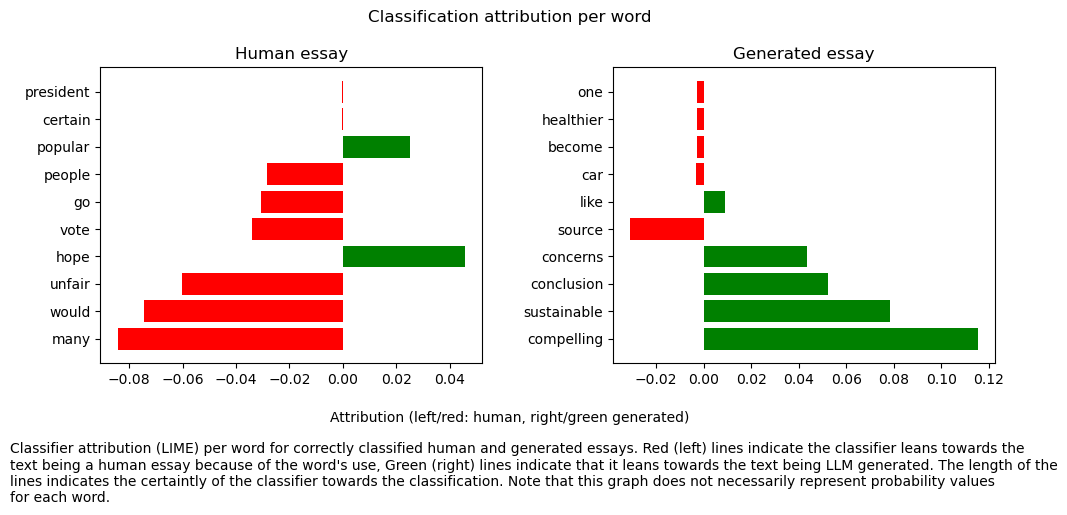

In [34]:
import matplotlib.pyplot as plt
import textwrap


# code for lime text and graph attributed to Ioannis Pavlopoulos
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# explanation for (correct) human classification
example_human = data_test[(data_test.generated == 0) & (best_pred == 0)].head(256)
exp_human = explainer.explain_instance(example_human.text.iloc[0] , c.predict_proba)
exp_human_reversed = [(name, -value) for name, value in exp_human.as_list()]
word_scores_human = pd.DataFrame(exp_human.as_list(), columns=["word", "xscore"]) 
word_scores_human['color'] = word_scores_human.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[0].barh(word_scores_human.word, word_scores_human.xscore, color=word_scores_human.color)
axes[0].set_title("Human essay")

# explanation for generated classification
example = data_test[(data_test.generated == 1) & (best_pred == 1)].head(256)
exp = explainer.explain_instance(example.text.iloc[0] , c.predict_proba)
word_scores = pd.DataFrame(exp.as_list(), columns=["word", "xscore"])
word_scores['color'] = word_scores.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[1].barh(word_scores.word, word_scores.xscore, color=word_scores.color)
axes[1].set_title("Generated essay")

caption_text = "Classifier attribution (LIME) per word for correctly classified human and generated essays. "\
                "Red (left) lines indicate the classifier leans towards the text being a human essay "\
                "because of the word's use, Green (right) lines indicate that it leans towards the text being LLM generated. "\
                "The length of the lines indicates the certaintly of the classifier towards the classification. "\
                "Note that this graph does not necessarily represent probability values for each word."

caption = textwrap.fill(caption_text, width=150)
fig.text(0, -0.25, caption)

fig.suptitle("Classification attribution per word")
fig.text(0.5, -0.05, 'Attribution (left/red: human, right/green generated)', ha='center')
fig.tight_layout(h_pad=3, w_pad=3) #believe it or not this *is* different from pad=3

save_plot("attribution.png")
plt.show()

## Analyzing the dataset

### Text Similarity

Another step towards interpreting the results of our classifiers is to gauge the characteristics of our dataset. We can estimate how easily distinquishable the two classes (generated / human) are by calculating the similary between each generated post compared to all human ones.

There are many similarity scores for text data, each with its own criteria, strength and weaknesses. Two of the most prominent ones are:
* Cosine Similarity, usually used for text embeddings
* Jaccard Similarity, which is applied to the raw text, and calculates the ratio of common to total words between the texts. This score is biased towards large texts and does not take into account multiple instances of a word.

For the purposes of our analysis we use the Jaccard Similarity, since the TF-IDF representation that we have chosen inherently uses the existence of words instead of their semantic meaning. Thus, the Jaccard Similarity score should be directly related to the ability of our classifiers to distinguish the classes in our dataset.

We will be computing the mean and max similarity for every generated text compared to all human texts.

In [35]:
generated_df = df[df.generated == 1]
human_df = df[df.generated == 0]

In [36]:
def jaccard_similarity(set1: set[str], set2: set[str]) -> float:
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union


mean_similarity = []
max_similarity = []

print("Calculating similarity scores...")
for x in tqdm(generated_df.text):
    similarities = []
    for y in human_df.text:
      similarities.append(jaccard_similarity(set(x.split()), set(y.split())))
                                        
    mean_similarity.append(np.mean(similarities))
    max_similarity.append(np.max(similarities))

similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

Calculating similarity scores...


  0%|          | 0/152 [00:00<?, ?it/s]

,id,text,mean,max
80,2773000545664,limiting car usage offers numerous advantages ...,0.070840,0.161692
81,2773038626192,limiting car usage presents myriad advantages ...,0.063066,0.146512
82,2773038634128,limiting car usage offers range advantages ext...,0.066002,0.165877
83,2773038638656,limiting car usage brings forth numerous advan...,0.062823,0.150000
84,2773040001136,limiting car usage presents myriad advantages ...,0.077351,0.187500
...,...,...,...,...
154,2773038835024,"dear , hey , hope 're good ! , 've thinking lo...",0.084648,0.170306
155,2773039396656,"dear , hope letter finds chill . wanted throw ...",0.088659,0.184211
704,82131f68,"essay analyze , discuss prove one reason favor...",0.073079,0.155405
740,86fe4f18,strongly believe electoral college remain way ...,0.077130,0.172840


In [37]:
similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

,id,text,mean,max
80,2773000545664,limiting car usage offers numerous advantages ...,0.070840,0.161692
81,2773038626192,limiting car usage presents myriad advantages ...,0.063066,0.146512
82,2773038634128,limiting car usage offers range advantages ext...,0.066002,0.165877
83,2773038638656,limiting car usage brings forth numerous advan...,0.062823,0.150000
84,2773040001136,limiting car usage presents myriad advantages ...,0.077351,0.187500
...,...,...,...,...
154,2773038835024,"dear , hey , hope 're good ! , 've thinking lo...",0.084648,0.170306
155,2773039396656,"dear , hope letter finds chill . wanted throw ...",0.088659,0.184211
704,82131f68,"essay analyze , discuss prove one reason favor...",0.073079,0.155405
740,86fe4f18,strongly believe electoral college remain way ...,0.077130,0.172840


And plot the results, to get a better picture of the results:

Figured saved to ..\output\similarity.png


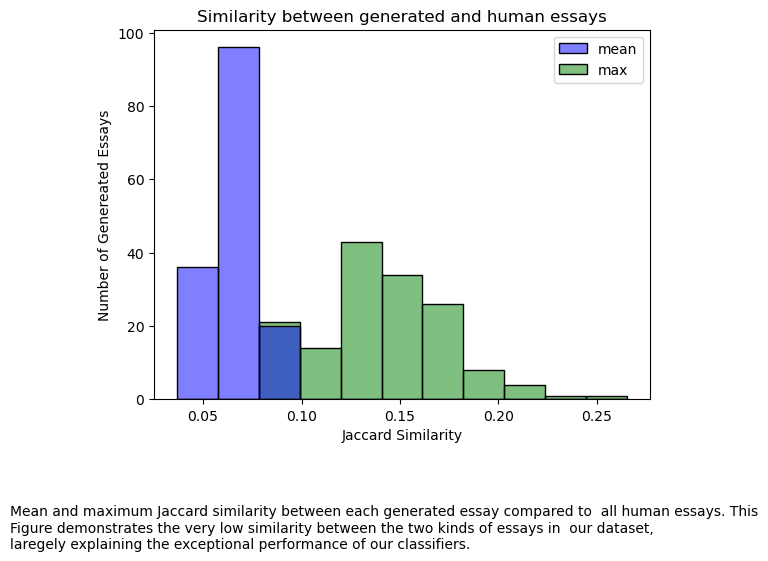

In [38]:
import seaborn as sns
import textwrap


sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"})

caption_text = """Mean and maximum Jaccard similarity between each generated essay compared to 
all human essays. This Figure demonstrates the very low similarity between the two kinds of essays in 
our dataset, laregely explaining the exceptional performance of our classifiers. 
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.2, caption)

plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of Genereated Essays")
plt.title("Similarity between generated and human essays")

save_plot("similarity.png")
plt.show()

### Leave-One-Out Cross Validation

By using LOOV-CV we can hopefully correlate the prediction probability of every generated text with its mean and max similarity with human texts, as described above.

In [39]:
probs = []

# TODO: look into this
print("Running Leave One Out validation for generated texts...")
for essay_id in tqdm(similarity_df.id):
    essay_train = df[~df.id.eq(essay_id)] 
    essay_test = df[df.id.eq(essay_id)]
    assert essay_test.shape[0] == 1, essay_id
    model = RandomForestClassifier(n_estimators=25)
    model = model.fit(vectorizer.transform(essay_train.text), essay_train.generated)
    probs.append(model.predict_proba(vectorizer.transform(essay_test)))

Running Leave One Out validation for generated texts...


  0%|          | 0/152 [00:00<?, ?it/s]

In [40]:
similarity_df["probs"] = [x[0][0] for x in probs]
similarity_df

,id,text,mean,max,probs
80,2773000545664,limiting car usage offers numerous advantages ...,0.070840,0.161692,1.0
81,2773038626192,limiting car usage presents myriad advantages ...,0.063066,0.146512,1.0
82,2773038634128,limiting car usage offers range advantages ext...,0.066002,0.165877,1.0
83,2773038638656,limiting car usage brings forth numerous advan...,0.062823,0.150000,1.0
84,2773040001136,limiting car usage presents myriad advantages ...,0.077351,0.187500,1.0
...,...,...,...,...,...
154,2773038835024,"dear , hey , hope 're good ! , 've thinking lo...",0.084648,0.170306,1.0
155,2773039396656,"dear , hope letter finds chill . wanted throw ...",0.088659,0.184211,1.0
704,82131f68,"essay analyze , discuss prove one reason favor...",0.073079,0.155405,1.0
740,86fe4f18,strongly believe electoral college remain way ...,0.077130,0.172840,1.0


The results do not surprise us, since as we saw from the classifier's Cross-Validation, training accuracy is very close to 100%. This is a consequence of our data and the problem at hand. Thus, we cannot run any meaningful analysis on the correlation between text similarity and probability.

### Impact of data size

Lastly, we can look at the progressive learning curve of our classifier's performance to gauge the quality of our data.

We split the training data into $[10%, 20%, \cdots, 100%]$ random splits, leaving the test set whole. We then train our best classifier in all of the successive splits and keep the accuracy metric. 

In [41]:
len_splits = np.arange(start=0.1, stop=1.1, step=0.1)
splits = [data_train.sample(int(np.ceil(data_train.shape[0]*i))) for i in len_splits]

sizes = [len(split) for split in splits]
sizes

[107, 214, 321, 428, 534, 641, 748, 855, 962, 1068]

In [42]:
from sklearn.metrics import f1_score


train_scores = []
test_scores = []

for split in splits:
    x_train = vectorizer.transform(split.text)
    y_train = split.generated
    model = best_model.fit(x_train, y_train)

    train_preds = model.predict(x_train)
    train_scores.append(f1_score(y_train, train_preds, average="macro"))
    test_preds = model.predict(x_test)
    test_scores.append(f1_score(y_test, test_preds, average="macro"))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

We now plot the accuracy metric (here Macro-F1 score for reasons outlined in the `Classifiers` section) in relation to the number of data points. 

A useful question would be how much data would we need to reach 100% test set accuracy. Since it's improbable that our classifier can reach this score with a reasonable amount of data we resort to using a regression plot on the test set accuracy metric. This has several caveats:
* The linearity assumption made by the (linear) regression plot is almost never accurate in training/test curves. The curves are oftentimes logarithmic, rapidly imporoving when only few data points exist, and plateauing after a certrain inflection point. For example, the performance of a classifier will improve more when we add 10 points from a previous dataset of 100, than if we add the same amount of points to a previous dataset of 10,000
* The shape of the curve will angle the regression line upwards since the first splits will almost certainly be much "lower" than the rest

Concluding, while we certainly can use a linear regression line to gauge the amount of data until we reach 100% test set accuracy, this prediction will almost certainly be overly optimistic.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Figured saved to ..\output\dataset_size.png


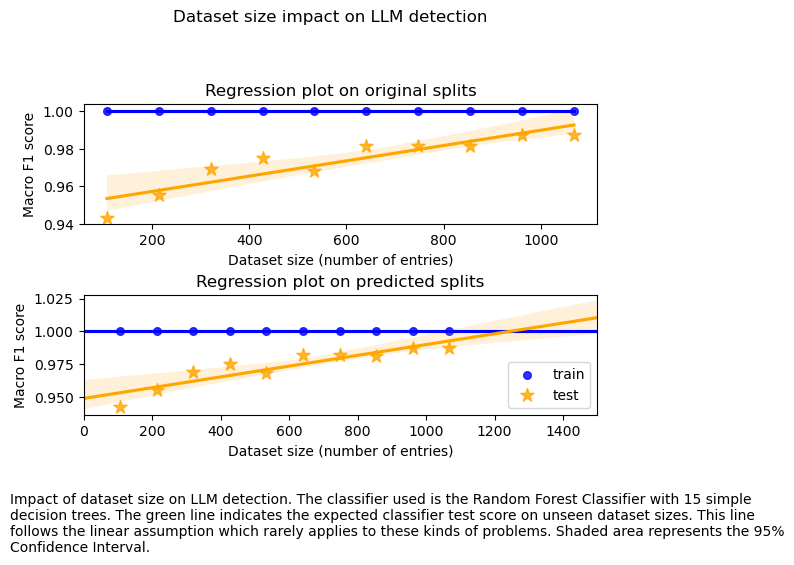

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle("Dataset size impact on LLM detection")
fig.tight_layout(pad=3)

# regular regplot
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax1,
            scatter_kws={"s": 30})
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax1,
            scatter_kws={"s": 100})

ax1.set_title("Regression plot on original splits")
ax1.set_ylabel("Macro F1 score")
ax1.set_xlabel("Dataset size (number of entries)")
plt.legend()


# regplot with expanded xlim
plt.xlim(0, 1500)
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            ax=ax2,
            scatter_kws={"s": 30},
            truncate=False)
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            ax=ax2,
            scatter_kws={"s": 100},
            truncate=False)

ax2.set_title("Regression plot on predicted splits")
ax2.set_ylabel("Macro F1 score")
ax2.set_xlabel("Dataset size (number of entries)")
plt.legend()

# TODO: come back to this once done with data and classifiers
caption_text = "Impact of dataset size on LLM detection. The classifier used is the "\
"Random Forest Classifier with 15 simple decision trees. The green line indicates "\
"the expected classifier test score on unseen dataset sizes. This line follows the "\
"linear assumption which rarely applies to these kinds of problems. Shaded area represents "\
"the 95% Confidence Interval."
caption = textwrap.fill(caption_text, width=110)
plt.figtext(0, -0.15, caption)

# save and show
save_plot("dataset_size.png")
plt.show()

## Clustering-based augmentation

In order to determine the "variance" of our generated samples, we can use clustering techniques to determine in which groups the human and generated essays belong in. Using those groups we can extract their similarities by looking into their individual members, and determine which groups may be underrepresented in our dataset.

### Methodology

Before we execute the clustering algorithm we need to determine the number of clusters in our data. This can be either done by intuition (if we already know how many classes *should* exist according to our problem), or by statistical techniques.

Our intuition would lead us to choose $2$ clusters for both generated and human essays, one for each prompt. However, we are interested in seeing if there are underlying patterns within those two large clusters, which is why we need to use the afforementioned techniques.

There are two main methods we can use to determine the number of clusters, the **Elbow** method and the **Silhouette** score. To simplify, the Elbow method determines the last point at which the model improves significantly while the Silhouette score determines the cluster cohesion. 

We follow the advice of [this post](https://builtin.com/data-science/elbow-method), which warns against relying on the Elbow method when its results are not decisive (which is often the case), and thus use both methods.

### Clustering Generated Essays

#### Determining the number of clusters

In [44]:
x_generated = vectorizer.transform(generated_df.text).toarray()
x_human = vectorizer.transform(human_df.text).toarray()

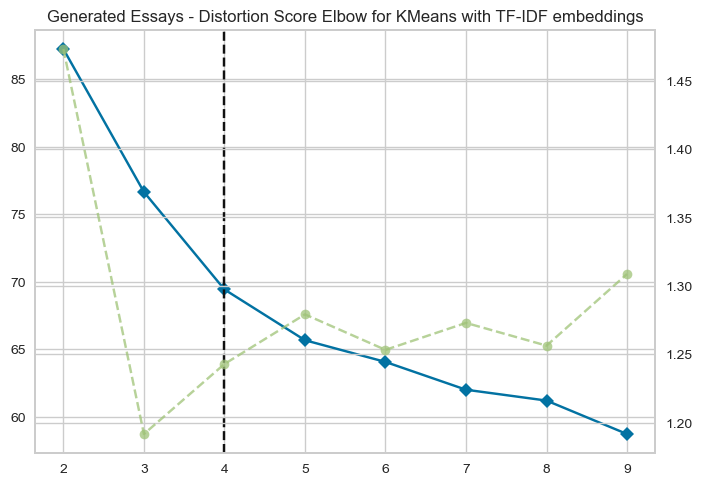

In [45]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


# code for the graphs adapted from https://builtin.com/data-science/elbow-method

# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_generated)        
    
plt.title("Generated Essays - Distortion Score Elbow for KMeans with TF-IDF embeddings")
plt.show()

While the Elbow method indicates that 4 clusters are optimal, there is no desicive "elbow" at any point in the graph. Thus, we will use the Silhouette method to hopefully get more reliable results.

Generating plots...


  0%|          | 0/6 [00:00<?, ?it/s]

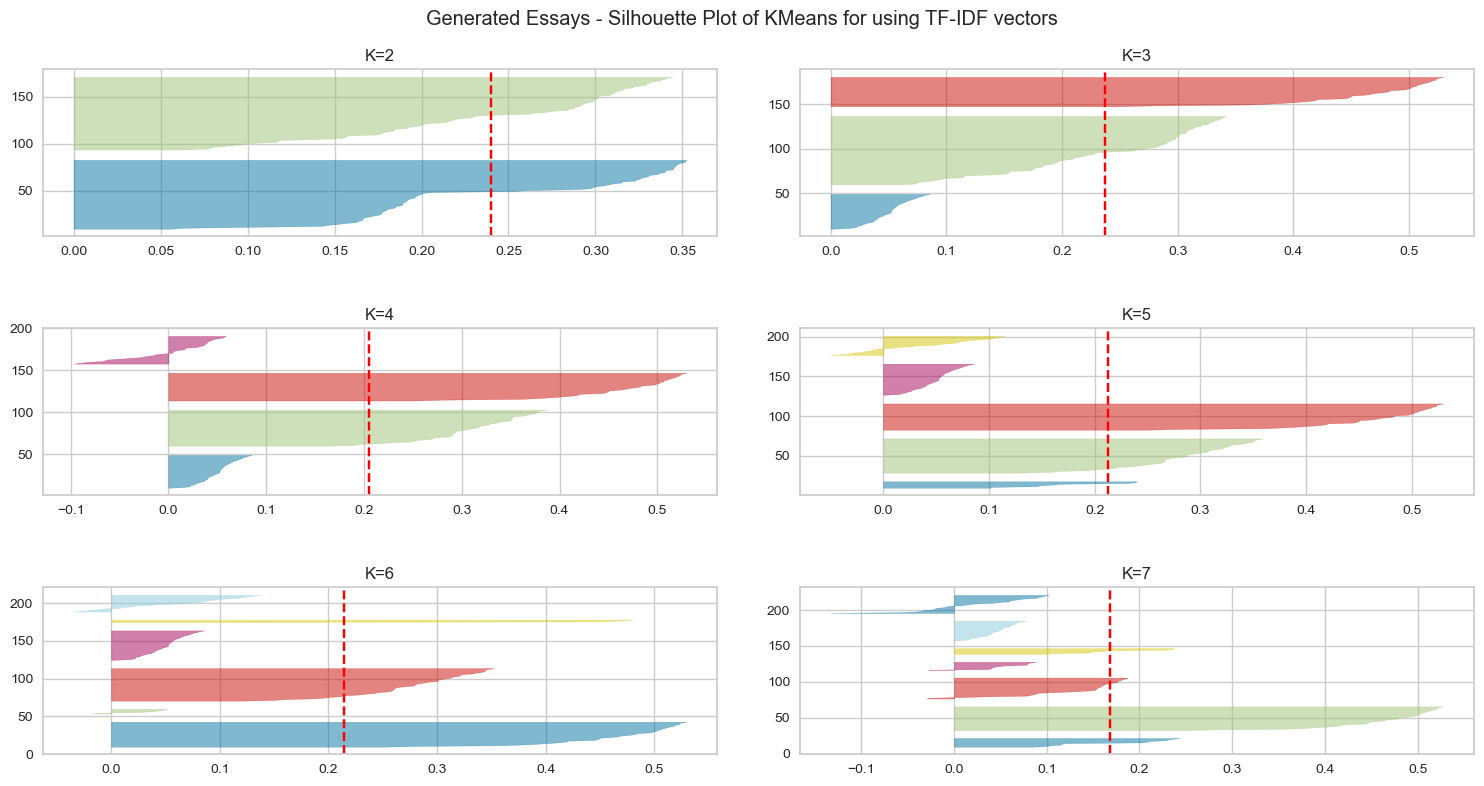

In [46]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_generated) 

fig.suptitle("Generated Essays - Silhouette Plot of KMeans for using TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

These graphs represent how similar the points in each cluster with each other compared to the ones from other clusters. The bigger the score, the more "sure" we are the point belongs in the cluster, while negative values indicate the point has probably been mis-clsutered. Each "blob" represents a cluster and the red line is the mean Silhouette score of all clusters.

We are looking for two main patterns in the graphs (we direct the reader to the [previous post](https://builtin.com/data-science/elbow-method) for details):
* All clusters must pass through the red line (all clusters must be signifcant)
* The cluster sizes should be as equal as possible.

Taking into account the two criteria, the optimal clustering for generated essays is $K=2$.

#### Determining the clusters

In order to qualitatetively assess the clustering we need to take a look at the clusters ourselves. The easiest and most reliable way is to print out a sample of each cluster and compare them.

In [47]:
def print_clusters(clusters, data_df, n_samples=2):
    for cluster in np.unique(clusters):
        print("=" * 100)
        print(f"Cluster {cluster}")
        for text in data_df[clusters==cluster].sample(n_samples).text:
            print("\t\t", text)

In [48]:
km = KMeans(n_clusters=2, 
            init="k-means++", 
            random_state=42, 
            n_init=10)
generated_clusters = km.fit_predict(x_embed_generated)
print_clusters(generated_clusters, generated_df)

NameError: name 'x_embed_generated' is not defined

It looks like the essays have been clustered according to their prompt, which confirms our intuition.

### Clustering Human Essays

#### Determining the number of clusters

We begin with the Elbow method, just like before.

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(x_human)        
    
plt.title("Human Essays - Distortion Score Elbow for KMeans")
plt.show()

This is an even more perplexing elbow graph, so we turn to Silhouette score to get a better picture.

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(x_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans for human essays with TF-IDF vectors")
fig.tight_layout(h_pad=3, w_pad=3)
plt.show()

While we could accept $K=2$ for the same merits as in the generated essays, we must acknowledge that the clustering is much more difficult in our case. A probable reason for that is that the TF-IDF representation on which the clustering is based on, is insufficient for the human essays, either due to its shape in the $l$ dimensional space, or because of sparsity.

A way to circumvent this limitation is swapping the text representation to the Word2Vec embeddings. While probably insufficient for classification, their low dimensionality and their much higher similarity with each other (which was determined in a previous version of this notebook) make them suitable candidates for clustering.

In [ ]:
embed_human = np.array([x for x in df.loc[df.generated==0].embedding])
fig, axes = plt.subplots(3, 2, figsize=(15,8))

print("Generating plots...")
for i in tqdm(range(2, 8)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(embed_human) 

fig.suptitle("Human Essays - Silhouette Plot of KMeans using Word2Vec embeddings")
fig.tight_layout(h_pad=3, w_pad=3) 
plt.show()

This is a much clearer graph, carrying very important information; unlike the generated clusters, the human essays seem to feature underlying patterns in their 2 main clusters, making the optimal clustering $K=4$.

#### Determining the clusters

We follow the same procedure as before:

In [ ]:
km = KMeans(n_clusters=4, 
                init="k-means++", 
                random_state=42, 
                n_init=10)
km = km.fit(embed_human)
human_clusters = km.predict(embed_human)
print_clusters(human_clusters, human_df)

Clusters 0 and 3 seem to feature prompts about car-free cities, while clusters 1 and 2 about the electoral college, corresponding to clusters 0 and 1 of the generated essay clusters respectively. 

The most notable difference between the clusters featuring the same prompts is that clusters 0 and 1 appear to stick closely to sources, citing them explicitly and often, and being much more likely to use text found in the sources themselves. Thus, we can yield a title for each cluster:

In [ ]:
cluster_mapping = {0: "Cars w/sources", 
                   1: "Election w/sources",
                   2: "Election no sources",
                   3: "Cars no sources"}

### Determining the balance of the clusters

In order to get a faithful representation of the student essays by our generated dataset, we should ensure that the generated essays correspond roughly proportionally to the student clusters. 

We will cluster the generated essays according to the K-means model we trained on human essays and compare the number of essays in each cluster:

In [ ]:
guessed_gen_clusters = km.predict(x_embed_generated)

In [ ]:
cluster_df = pd.DataFrame({"clusters": np.concatenate([
                                guessed_gen_clusters, 
                                human_clusters]),
                          "generated": np.concatenate([
                              np.ones_like(guessed_gen_clusters), 
                              np.zeros_like(human_clusters)])})

cluster_df.cluster = cluster_df.cluster.map(cluster_mapping)
cluster_df

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

cluster_human_df = cluster_df[cluster_df.generated == 0]
cluster_human_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax1)
ax1.set_title("Human Essays")
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Number of essays")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


gen_human_df = cluster_df[cluster_df.generated == 1]
gen_human_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'],
    ax=ax2)
ax2.set_title("Generated Essays")
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Number of essays")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

fig.suptitle("Number of essays per cluster")
save_plot("clusters.png")
plt.show()

### Dataset augmentation

We have determined that the most important weakness in our dataset is the lack of generated essays about car-free cities, which do not follow the source closely. We prompt ChatGPT with prompts explicitly against citing sources directly, and add them to our dataset.

In [ ]:
extra_cars_df = create_gpt_dataset("cluster_augmentation_cars.md", prompt_id=0)
extra_cars_df.head()

In [ ]:
extra_cars_df.shape

### Training the best classifier with the augmented data

We can now retrain our best classifier with the extra data and check whether our more balanced dataset helps improve its performace.

In [ ]:
extra_cars_df_prepr = extra_cars_df.copy()
extra_cars_df_prepr.text = preprocess(extra_cars_df_prepr.text)
extra_cars_df_prepr["embedding"] = compute_embeddings(extra_cars_df_prepr.text) 

In [ ]:
augmented_df_prepr = pd.concat([extra_cars_df_prepr, df])
augmented_df_prepr

In [ ]:
data_train, data_test = train_test_split(augmented_df_prepr,
                                        train_size=0.7,
                                        test_size=0.3,
                                        stratify=augmented_df.generated,
                                         random_state=42)
data = get_data_from_text(data_train, data_test)

x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]

In [ ]:
res = cross_val_res(best_model, x_train, y_train)
print(f"Best model withTF-IDF vectors Macro-F1:\n mean:{res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
best_model = best_model.fit(x_train, y_train)
preds = best_model.predict(x_test)

print(classification_report(y_test, preds))

We can see that our classifier hasn't significantly improved, which normally may indicate that the cluster imbalance didn't affect our dataset. However, since our test score was already close to 1, it probably indicates that our classifier cannot reach 100% performance (which for operational data would be utopic) with just a few more datapoints. 

## Exporting the full dataset

The full dataset comprises the (few) generated prompts provided to us as well as all the generated prompts we generated (even if only a subset was used for the purposes of this notebook).

Asides from meta-information included in the original dataset we also include a column representing the cluster of each essay according to the K-Means model fitted on the human essays.

In [ ]:
full_df = pd.concat([envir_df, elect_df, extra_cars_df, original_df[original_df.generated==1]])
full_df = full_df.loc[:, ["id", "text", "prompt_id", "generated"]]
full_df

In [ ]:
print("Determining clusters:")
print("\tPreprocessing...")
full_text = preprocess(full_df.text)
print("\tDone.")

print("\t", end="")
full_embeddings = compute_embeddings(full_text)
clusters = km.predict(np.array([x for x in full_embeddings]))
print("\tDone.")

full_df["cluster"] = clusters
full_df.cluster = full_df.cluster.map(cluster_mapping)
full_df

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.tight_layout(pad=2.0)
fig.suptitle("Augmentation Dataset Statistics")

axes[0].pie(full_df.prompt_id.value_counts(), 
        labels=["Car-Free cities", "Electoral College"], 
        textprops={'fontsize': 11},
        colors=["orange", "green"],
        autopct=f'%1.1f%%')
axes[0].set_title("Prompts")


axes[1].pie(full_df.cluster.value_counts(), 
        labels=cluster_mapping.values(), 
        textprops={'fontsize': 11},
        autopct=f'%1.1f%%')
axes[1].set_title("Category")

save_plot("augmentation_stats.png")
plt.show()

In [ ]:
csv_output(full_df, "augmentation.csv")